In [8]:
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = [9, 8]
import cv2
import numpy as np
import xml.etree.ElementTree as ET


In [9]:
def imshow(image):
    if (len(image.shape)==2):
        plt.imshow(image,cmap="gray")
    else:
        plt.imshow(image[:,:,::-1])
def resize(img, ratio):
    width = int(img.shape[1] * ratio)
    height = int(img.shape[0] * ratio)
    dim = (width, height)
    return cv2.resize(img, dim, interpolation = cv2.INTER_AREA)

In [10]:
# get coordinate of correct bounding box
def getCorrectBound(filename):
    name = filename.rsplit('.', 1)[0]
    tree = ET.parse(name + ".xml")
    root = tree.getroot();
    bounds = root.findall('.//bndbox')

    # variable for store bounding box
    bound_coordinates = []
    for bound in bounds:
        # xmin, ymin, xmax, ymax
        coordinate = []
        for tag in bound.findall('./*'):
            coordinate.append(int(tag.text));
        bound_coordinates.append(coordinate)

    #draw bounding box on picture
    image = cv2.imread(filename)
    copy_image = image.copy()

    for bound in bound_coordinates:
        cv2.rectangle(copy_image,(bound[0],bound[1]),(bound[2],bound[3]),(0,0,255),1)
    return bound_coordinates

In [11]:
def iou(boxA, boxB):
    # determine the (x, y)-coordinates of the intersection rectangle
    xTopLeft = max(boxA[0], boxB[0])
    yTopLeft = max(boxA[1], boxB[1])
    xBottomRight = min(boxA[2], boxB[2])
    yBottomRight = min(boxA[3], boxB[3])
    # caculate intersection rectangle's area
    interArea = max(0, xBottomRight - xTopLeft + 1) * max(0, yBottomRight - yTopLeft + 1)
    # caculate boxes's area
    boxAArea = (boxA[2] - boxA[0] + 1) * (boxA[3] - boxA[1] + 1)
    boxBArea = (boxB[2] - boxB[0] + 1) * (boxB[3] - boxB[1] + 1)
    # union area = areas - the interesection area
    iou = interArea / float(boxAArea + boxBArea - interArea)
    # return the intersection over union value
    return iou

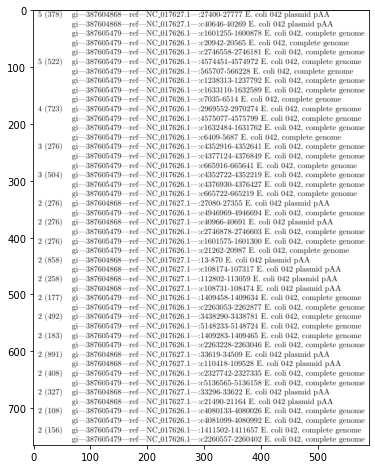

In [12]:
# image for demo: 48866(anh mau), 19(anh khong duong), 32(anh co duong), 49392(anh ghep nhieu hang), 75011
image = cv2.imread('train/75048.png')
result = image.copy()
bound_coordinates = getCorrectBound('train/75048.png')
imshow(result)

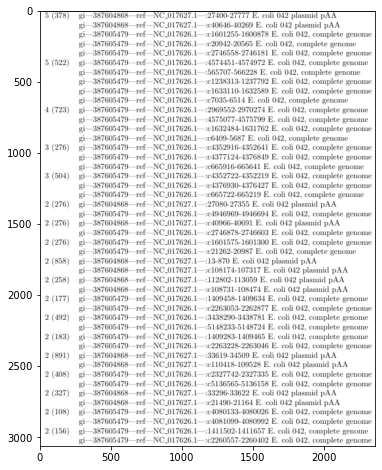

In [13]:
result = resize(result, 4)
# result=cv2.pyrUp(result)
# result=cv2.pyrUp(result)
imshow(result)

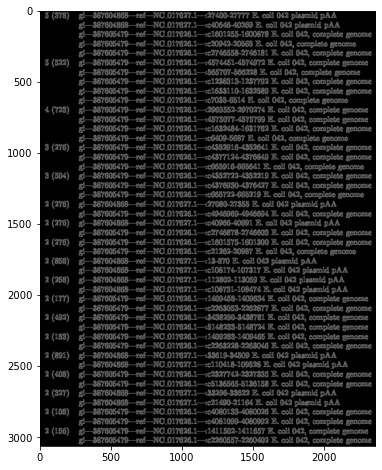

In [14]:
gray = cv2.cvtColor(result,cv2.COLOR_BGR2GRAY)   

canny = cv2.Canny(gray, 10, 50)
cannyres = canny.copy()
imshow(canny)

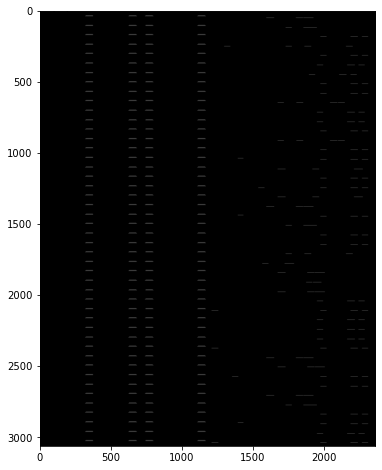

In [15]:
# Remove horizontal lines
horizontal_kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (40,1))
remove_horizontal = cv2.morphologyEx(cannyres, cv2.MORPH_OPEN, horizontal_kernel, iterations=1)
imshow(remove_horizontal)


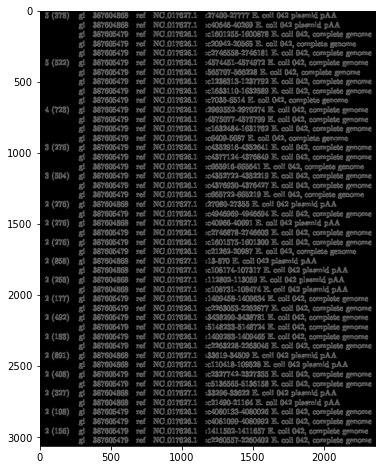

In [16]:

cnts = cv2.findContours(remove_horizontal, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
cnts = cnts[0] if len(cnts) == 2 else cnts[1]
for c in cnts:
    cv2.drawContours(canny, [c], -1, (0,0,0), 2)
imshow(canny)

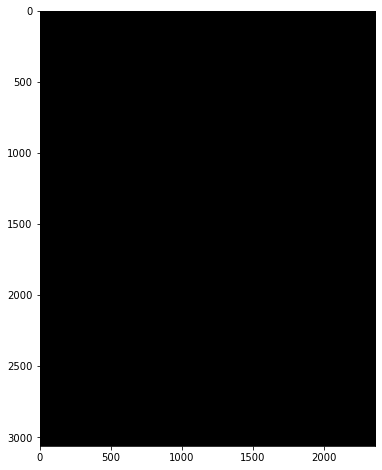

In [17]:
# Remove vertical lines
vertical_kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (1,28))
remove_vertical = cv2.morphologyEx(cannyres, cv2.MORPH_OPEN, vertical_kernel, iterations=2)
imshow(remove_vertical)


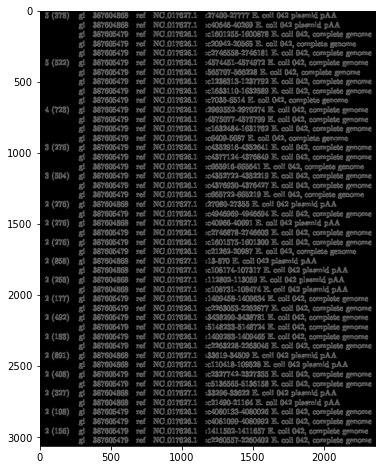

In [18]:
cnts = cv2.findContours(remove_vertical, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
cnts = cnts[0] if len(cnts) == 2 else cnts[1]
for c in cnts:
    cv2.drawContours(canny, [c], -1, (0,0,0), 4)
imshow(canny)

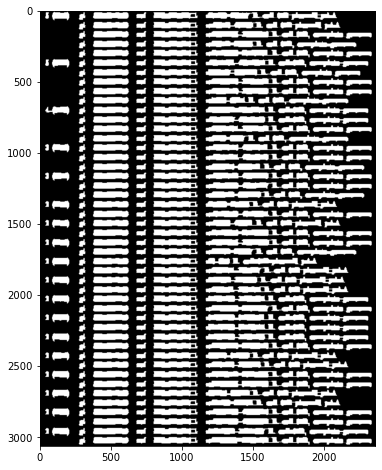

In [19]:
#connected = thresh.copy()
kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (12, 6))
connected = cv2.dilate(canny, kernel, iterations=2)
connected = cv2.erode(connected, kernel, iterations=2)
imshow(connected)

0.31
iou: 0.41751179948455636


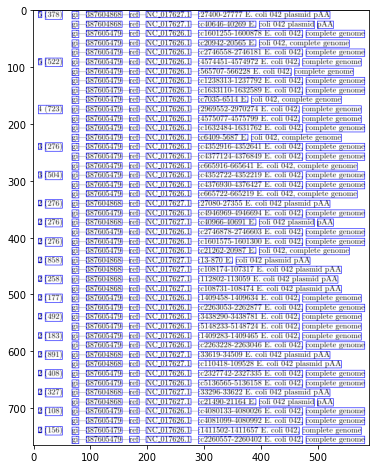

In [23]:
n_connected = resize(connected, 1/4)
contours, hierarchy = cv2.findContours(n_connected.copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_NONE)

iou_arr = []
correctCellsImage = 0
cellsImage = 0
dt_bounds = []

image1 = image.copy()
for idx in range(len(contours)):
    x, y, w, h = cv2.boundingRect(contours[idx])
    
    if w > 4 and h > 4:
        cv2.rectangle(image1, (x, y), (x+w-1, y+h-1), (255, 0, 0), 1)
        dt_bound = [x,y,x+w-1,y+h-1]
        dt_bounds.append(dt_bound)

for bound in bound_coordinates:
    max_iou = 0
    for dt_bound in dt_bounds:
        iou_value = iou(dt_bound,bound)
        max_iou = max(max_iou,iou_value)
    if (max_iou > 0.5):
        correctCellsImage += 1
    cellsImage += 1
    iou_arr.append(max_iou)
precisionImage = round(correctCellsImage/cellsImage,2)
print("precision" + str(precisionImage))
print("iou: " + str(sum(iou_arr)/len(iou_arr)))
imshow(image1)